# Part 1: Set up & load data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#Pytorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=True, transform=transform)
validation_set = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.14MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.14MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.9MB/s]


In [3]:
TRAIN_BATCH_SIZE = 4
training_loader = torch.utils.data.DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE,
                                             shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=TRAIN_BATCH_SIZE,
                                             shuffle=False)

# All images here are 28x28 sized.

In [4]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


# Part 2: Data validation & visualization

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim = 0)
  img = img/2 + 0.5 # Unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)


Image size: torch.Size([1, 28, 28])
          Bag           Bag         Sneaker         Pullover


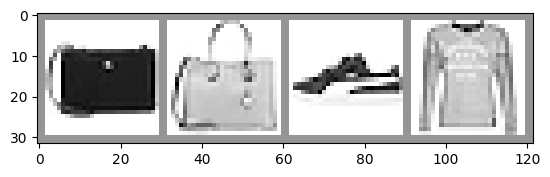

In [6]:
images, labels = dataiter.__next__()

img_grid = torchvision.utils.make_grid(images)
imshow(torchvision.utils.make_grid(images), one_channel=True)

print('Image size: {}'.format(images[0].shape))
print('        ' + '         '.join('%5s' % classes[labels[j]] for j in range(TRAIN_BATCH_SIZE)))

# Part 3: Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        # down sampling (reduce size) - take max of each (2x2) submatrix
        self.pool = nn.MaxPool2d(2, 2)
        # 1 - input channel, 6 - number of output channels (6 feature maps), 5 - kernel size
        # => map size = 28-5+1 = 24
        # after pool => map size = 12
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 6 - input channel, 16 - number of output channels (16 feature maps), 5 - kernel size
        # => map size = 12 - 5 + 1 = 8
        # => after pool => map size = 4
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Flatten (4 x 4 feature) x 16 channels.
        # Then just do normal multi layer neuron: 16*4*4 -> 120 -> 84 -> 10
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # fully connecttion
        self.fc2 = nn.Linear(120, 84) # fully connection
        self.fc3 = nn.Linear(84, 10) # fully connection. 10 is size of classification set


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) # Flatten?
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [9]:
# Demonstration purpose of how loss function works

loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.9691, 0.4155, 0.0860, 0.4226, 0.0760, 0.9440, 0.6090, 0.1553, 0.4763,
         0.4035],
        [0.8716, 0.6896, 0.2524, 0.5533, 0.9679, 0.6923, 0.9546, 0.0321, 0.1593,
         0.6515],
        [0.1306, 0.2738, 0.3573, 0.2621, 0.5701, 0.3672, 0.7103, 0.2051, 0.3693,
         0.3600],
        [0.5785, 0.2318, 0.3659, 0.2677, 0.7739, 0.2991, 0.5679, 0.7061, 0.6996,
         0.4764]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2886431217193604


In [10]:
# Optimizers specified in the torch.optim package
# model.parameters() => Return an interator to the list of **reference** of each parameter
# It means optimzier.step() will change the parameters without NN
# optimizer.zero_grad() => zero out all of slope in each params of NN
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [11]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch. `model(inputs)` is equivalent to `mode.forward(inputs)`
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [12]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization. => when we only care about the input -> model -> output
    # This is because we no longer want to train here
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.6994739711880684
  batch 2000 loss: 0.8570371145792306
  batch 3000 loss: 0.7192972814235836
  batch 4000 loss: 0.6311017468948849
  batch 5000 loss: 0.5832037721201777
  batch 6000 loss: 0.5495494324297179
  batch 7000 loss: 0.5333900610180572
  batch 8000 loss: 0.4878353345741052
  batch 9000 loss: 0.4953006903352216
  batch 10000 loss: 0.4977128563872539
  batch 11000 loss: 0.4779551656998228
  batch 12000 loss: 0.4526813723007799
  batch 13000 loss: 0.42002115652262
  batch 14000 loss: 0.4356828175925184
  batch 15000 loss: 0.4472652286606608
LOSS train 0.4472652286606608 valid 0.46031856536865234
EPOCH 2:
  batch 1000 loss: 0.41590874221670676
  batch 2000 loss: 0.4059416936820489
  batch 3000 loss: 0.38652128791209545
  batch 4000 loss: 0.4098192389215983
  batch 5000 loss: 0.4147870429312752
  batch 6000 loss: 0.36958256146241913
  batch 7000 loss: 0.37981118273682657
  batch 8000 loss: 0.38980977792554766
  batch 9000 loss: 0.37418045533960687
  ba

# Part 4: Prediction

In [30]:
model.eval()

dataiter = iter(validation_loader)

Image size: torch.Size([1, 28, 28])
Label:  Dress         Dress           Bag         T-shirt/top
Output: Dress         Dress           Bag         T-shirt/top


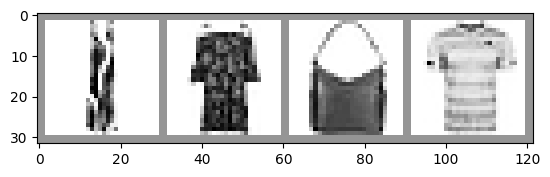

In [39]:
# Run multiple time to get predictions of multiple batch in validation set

images, labels = dataiter.__next__()
img_grid = torchvision.utils.make_grid(images)
imshow(torchvision.utils.make_grid(images), one_channel=True)
print('Image size: {}'.format(images[0].shape))
print('Label:  ' + '         '.join('%5s' % classes[labels[j]] for j in range(TRAIN_BATCH_SIZE)))
predictions = model(images)
_, predicted = torch.max(predictions, 1)
print('Output: ' + '         '.join('%5s' % classes[predicted[j]] for j in range(TRAIN_BATCH_SIZE)))